`antman` conda environment

Generate plot of polyA-enriched and rRNA-depleted RNA-seq coverage across a tandem array, split by strand. 

In [ ]:
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import sys
sys.path.append('../')
from transcriptomics import * 
from plotting import * 

# Set pandas display options
pd.set_option('display.max_columns', None)

# Load genome
genome_fasta_path = '../genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

Initializing transcriptomics package
Initializing plotting package


## Plot coverage of a tandem array 

In [3]:
def get_coverage_rRNA_depleted(tissue, orientation, chrom, start, end): 
    base_path = '../first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{tissue}_renamed_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]


In [4]:
def get_coverage_polyA_female(sample, orientation, chrom, start, end): 
    base_path = '../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{sample}_Aligned.sortedByCoord.out_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]

## T79

T79: Chr1:17883604-17944013


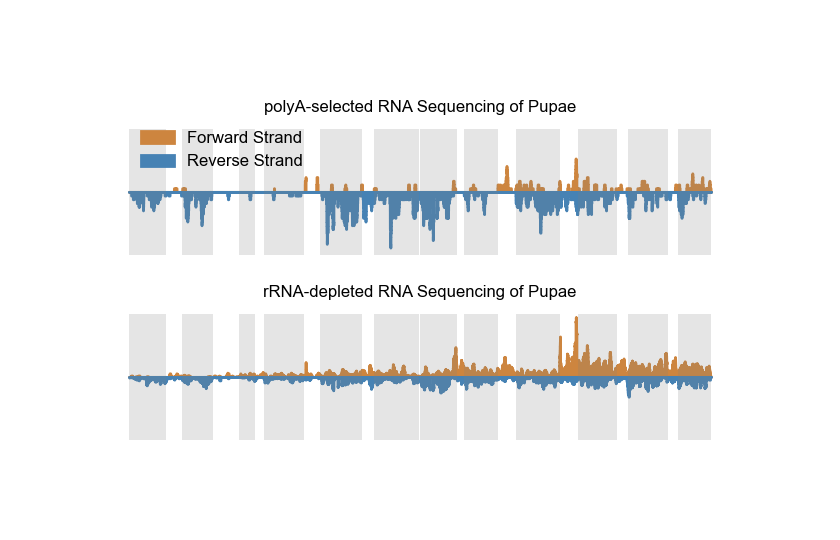

In [9]:
# Tandem Array Info
TA = 79
ta_genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values
ta_chr = tr.get_gene(ta_genes[0]).chromosome

# Get gene bounds
ta_gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in ta_genes]
ta_start, ta_end = min([bounds[0] for bounds in ta_gene_bounds]), max([bounds[1] for bounds in ta_gene_bounds])
print(f"T{TA}: {ta_chr}:{ta_start}-{ta_end}")

fig, axs = plt.subplots(2, 1, figsize=(3.5, 2), dpi=200)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Plot coverage of mRNA sequencing of female pupae 
sample = 'F1'
fwd_coverage = get_coverage_polyA_female(sample, 'fwd', ta_chr, ta_start, ta_end)
rev_coverage = get_coverage_polyA_female(sample, 'rev', ta_chr, ta_start, ta_end)
# Plot coverage of mRNA sequencing of pupae using rRNA depleted data, filling in the space between the plot and the x-axis
axs[0].fill_between(np.arange(ta_start, ta_end), fwd_coverage, color='peru', alpha=1, label='Forward Strand')
axs[0].fill_between(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='steelblue', alpha=1, label='Reverse Strand')
for ta_gene_bound in ta_gene_bounds: 
    axs[0].axvspan(ta_gene_bound[0], ta_gene_bound[1], color='grey', alpha=0.2, lw=0) 
axs[0].set_title(f"polyA-selected RNA Sequencing of Pupae", fontsize=6)
axs[0].set_ylabel('')
ylim = max(max(fwd_coverage), max(rev_coverage)) + 2
axs[0].set_ylim(-ylim, ylim)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend(loc='upper left', fontsize=6, bbox_to_anchor=(0.04, 1.1), frameon=False) 
axs[0].axis('off')

# Plot coverage of mRNA sequencing of pupae using rRNA depleted data 
tissue = 'Pupae_S5'
fwd_coverage = get_coverage_rRNA_depleted(tissue, 'fwd', ta_chr, ta_start, ta_end)
rev_coverage = get_coverage_rRNA_depleted(tissue, 'rev', ta_chr, ta_start, ta_end)
ylim = max(max(fwd_coverage), max(rev_coverage)) + 5
axs[1].fill_between(np.arange(ta_start, ta_end), fwd_coverage, color='peru', alpha=1, label='Forward Strand')
axs[1].fill_between(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='steelblue', alpha=1, label='Reverse Strand')
# Make grey bars where the gene bounds are 
for ta_gene_bound in ta_gene_bounds: 
    axs[1].axvspan(ta_gene_bound[0], ta_gene_bound[1], color='grey', alpha=0.2, lw=0)
axs[1].set_title(f"rRNA-depleted RNA Sequencing of Pupae", fontsize=6)
axs[1].set_ylabel('')
axs[1].set_ylim(-ylim, ylim)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].axis('off')

# Finalize and Show
plt.tight_layout()
plt.savefig(f"../figures/t79-rRNA-and-polyA-coverage.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()
